# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, `you'll use networks trained on ImageNet available from torchvision.`






In [54]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import tqdm

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

In [55]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data

# Dúvida: como saber quais transformações utilizar?

train_transforms = transforms.Compose([transforms.RandomRotation(30),       
                                       transforms.RandomResizedCrop(224),   
                                       transforms.RandomHorizontalFlip(),   
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)


We can load in a model such as DenseNet. Let's print out the model architecture so we can see what's going on.

In [56]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [57]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [58]:
import time

In [59]:
from torch.autograd import Variable

for cuda in [False, True]:
    
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
    if cuda:
        model.cuda()
    else:
        model.cpu()
        
    for ii, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(labels)
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            
        start = time.time()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if ii==3:
            break
        
    print(f"CUDA = {cuda}; TIme per batch: {(time.time() - start)/3:.3f} seconds")
        

CUDA = False; TIme per batch: 2.019 seconds
CUDA = True; TIme per batch: 0.008 seconds


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [62]:
for param in model.parameters():
    param.requires_grad = False
    
    
#  (fc): Linear(in_features=2048, out_features=1000, bias=True)

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier
    

In [63]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
criterion = nn.NLLLoss() #loss function

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

In [66]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.269.. Test loss: 0.097.. Test accuracy: 0.963
Epoch 1/1.. Train loss: 0.242.. Test loss: 0.082.. Test accuracy: 0.974
Epoch 1/1.. Train loss: 0.196.. Test loss: 0.086.. Test accuracy: 0.966


KeyboardInterrupt: 

In [67]:
from tqdm import tqdm

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % print_every == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, criterion, optimizer)
    test(testloader, model, criterion)
print("Done!")


Epoch 1
-------------------------------


  0%|          | 1/352 [00:04<27:23,  4.68s/it]

loss: 0.294676  [    0/22500]


  2%|▏         | 6/352 [00:24<28:02,  4.86s/it]

loss: 0.215043  [  320/22500]


  3%|▎         | 11/352 [00:43<27:10,  4.78s/it]

loss: 0.144876  [  640/22500]


  5%|▍         | 16/352 [01:02<27:22,  4.89s/it]

loss: 0.200563  [  960/22500]


  6%|▌         | 21/352 [01:20<24:53,  4.51s/it]

loss: 0.157704  [ 1280/22500]


  7%|▋         | 26/352 [01:39<25:55,  4.77s/it]

loss: 0.191398  [ 1600/22500]


  9%|▉         | 31/352 [01:59<25:56,  4.85s/it]

loss: 0.122662  [ 1920/22500]


 10%|█         | 36/352 [02:17<25:10,  4.78s/it]

loss: 0.148979  [ 2240/22500]


 12%|█▏        | 41/352 [02:37<24:57,  4.82s/it]

loss: 0.372748  [ 2560/22500]


 13%|█▎        | 46/352 [02:56<24:30,  4.81s/it]

loss: 0.387447  [ 2880/22500]


 14%|█▍        | 51/352 [03:15<23:52,  4.76s/it]

loss: 0.132810  [ 3200/22500]


 16%|█▌        | 56/352 [03:34<23:28,  4.76s/it]

loss: 0.141026  [ 3520/22500]


 17%|█▋        | 61/352 [03:53<23:16,  4.80s/it]

loss: 0.178650  [ 3840/22500]


 19%|█▉        | 66/352 [04:12<22:11,  4.66s/it]

loss: 0.117706  [ 4160/22500]


 20%|██        | 71/352 [04:30<21:13,  4.53s/it]

loss: 0.227024  [ 4480/22500]


 22%|██▏       | 76/352 [04:49<21:52,  4.76s/it]

loss: 0.067305  [ 4800/22500]


 23%|██▎       | 81/352 [05:08<21:26,  4.75s/it]

loss: 0.269275  [ 5120/22500]


 24%|██▍       | 86/352 [05:27<21:06,  4.76s/it]

loss: 0.131272  [ 5440/22500]


 26%|██▌       | 91/352 [05:47<20:45,  4.77s/it]

loss: 0.114580  [ 5760/22500]


 27%|██▋       | 96/352 [06:06<20:21,  4.77s/it]

loss: 0.074096  [ 6080/22500]


 29%|██▊       | 101/352 [06:25<20:05,  4.80s/it]

loss: 0.175183  [ 6400/22500]


 30%|███       | 106/352 [06:44<19:46,  4.82s/it]

loss: 0.138594  [ 6720/22500]


 32%|███▏      | 111/352 [07:03<19:13,  4.79s/it]

loss: 0.168479  [ 7040/22500]


 33%|███▎      | 116/352 [07:22<18:37,  4.73s/it]

loss: 0.175926  [ 7360/22500]


 34%|███▍      | 121/352 [07:40<18:05,  4.70s/it]

loss: 0.154737  [ 7680/22500]


 36%|███▌      | 126/352 [07:59<17:52,  4.75s/it]

loss: 0.229106  [ 8000/22500]


 37%|███▋      | 131/352 [08:18<17:26,  4.73s/it]

loss: 0.122378  [ 8320/22500]


 39%|███▊      | 136/352 [08:37<17:17,  4.80s/it]

loss: 0.093653  [ 8640/22500]


 40%|████      | 141/352 [08:56<16:53,  4.80s/it]

loss: 0.141689  [ 8960/22500]


 41%|████▏     | 146/352 [09:15<16:26,  4.79s/it]

loss: 0.130107  [ 9280/22500]


 43%|████▎     | 151/352 [09:35<16:17,  4.86s/it]

loss: 0.205209  [ 9600/22500]


 44%|████▍     | 156/352 [09:54<15:42,  4.81s/it]

loss: 0.198194  [ 9920/22500]


 46%|████▌     | 161/352 [10:13<15:10,  4.77s/it]

loss: 0.200006  [10240/22500]


 47%|████▋     | 166/352 [10:31<14:15,  4.60s/it]

loss: 0.327844  [10560/22500]


 49%|████▊     | 171/352 [10:50<14:18,  4.74s/it]

loss: 0.242912  [10880/22500]


 50%|█████     | 176/352 [11:09<13:59,  4.77s/it]

loss: 0.171537  [11200/22500]


 51%|█████▏    | 181/352 [11:28<13:39,  4.79s/it]

loss: 0.235897  [11520/22500]


 53%|█████▎    | 186/352 [11:48<13:17,  4.81s/it]

loss: 0.237219  [11840/22500]


 54%|█████▍    | 191/352 [12:07<12:49,  4.78s/it]

loss: 0.179390  [12160/22500]


 56%|█████▌    | 196/352 [12:26<12:18,  4.74s/it]

loss: 0.112864  [12480/22500]


 57%|█████▋    | 201/352 [12:45<12:05,  4.80s/it]

loss: 0.171503  [12800/22500]


 59%|█████▊    | 206/352 [13:04<11:33,  4.75s/it]

loss: 0.232176  [13120/22500]


 60%|█████▉    | 211/352 [13:23<11:09,  4.75s/it]

loss: 0.074584  [13440/22500]


 61%|██████▏   | 216/352 [13:42<10:45,  4.75s/it]

loss: 0.116240  [13760/22500]


 63%|██████▎   | 221/352 [14:01<10:27,  4.79s/it]

loss: 0.100418  [14080/22500]


 64%|██████▍   | 226/352 [14:20<10:06,  4.81s/it]

loss: 0.069284  [14400/22500]


 66%|██████▌   | 231/352 [14:39<09:38,  4.78s/it]

loss: 0.122919  [14720/22500]


 67%|██████▋   | 236/352 [14:59<09:22,  4.85s/it]

loss: 0.082935  [15040/22500]


 68%|██████▊   | 241/352 [15:18<08:56,  4.84s/it]

loss: 0.212626  [15360/22500]


 70%|██████▉   | 246/352 [15:37<08:27,  4.79s/it]

loss: 0.125372  [15680/22500]


 71%|███████▏  | 251/352 [15:56<08:05,  4.81s/it]

loss: 0.093228  [16000/22500]


 73%|███████▎  | 256/352 [16:15<07:40,  4.79s/it]

loss: 0.133840  [16320/22500]


 74%|███████▍  | 261/352 [16:34<07:12,  4.75s/it]

loss: 0.088532  [16640/22500]


 76%|███████▌  | 266/352 [16:54<06:53,  4.81s/it]

loss: 0.117629  [16960/22500]


 77%|███████▋  | 271/352 [17:13<06:27,  4.79s/it]

loss: 0.170713  [17280/22500]


 78%|███████▊  | 276/352 [17:32<06:06,  4.83s/it]

loss: 0.278566  [17600/22500]


 80%|███████▉  | 281/352 [17:52<05:44,  4.85s/it]

loss: 0.206606  [17920/22500]


 81%|████████▏ | 286/352 [18:11<05:15,  4.78s/it]

loss: 0.311999  [18240/22500]


 83%|████████▎ | 291/352 [18:29<04:50,  4.76s/it]

loss: 0.139355  [18560/22500]


 84%|████████▍ | 296/352 [18:49<04:29,  4.81s/it]

loss: 0.122574  [18880/22500]


 86%|████████▌ | 301/352 [19:08<04:03,  4.77s/it]

loss: 0.256368  [19200/22500]


 87%|████████▋ | 306/352 [19:27<03:42,  4.83s/it]

loss: 0.089141  [19520/22500]


 88%|████████▊ | 311/352 [19:47<03:19,  4.86s/it]

loss: 0.364030  [19840/22500]


 90%|████████▉ | 316/352 [20:06<02:51,  4.77s/it]

loss: 0.433273  [20160/22500]


 91%|█████████ | 321/352 [20:25<02:30,  4.85s/it]

loss: 0.315827  [20480/22500]


 93%|█████████▎| 326/352 [20:44<02:03,  4.74s/it]

loss: 0.112059  [20800/22500]


 94%|█████████▍| 331/352 [21:03<01:39,  4.74s/it]

loss: 0.111568  [21120/22500]


 95%|█████████▌| 336/352 [21:22<01:17,  4.84s/it]

loss: 0.192613  [21440/22500]


 97%|█████████▋| 341/352 [21:41<00:52,  4.79s/it]

loss: 0.274564  [21760/22500]


 98%|█████████▊| 346/352 [22:00<00:28,  4.80s/it]

loss: 0.115175  [22080/22500]


100%|█████████▉| 351/352 [22:19<00:04,  4.88s/it]

loss: 0.087377  [22400/22500]


100%|██████████| 79/79 [02:33<00:00,  1.94s/it]

Test Error: 
 Accuracy: 98.3%, Avg loss: 0.046683 

Done!


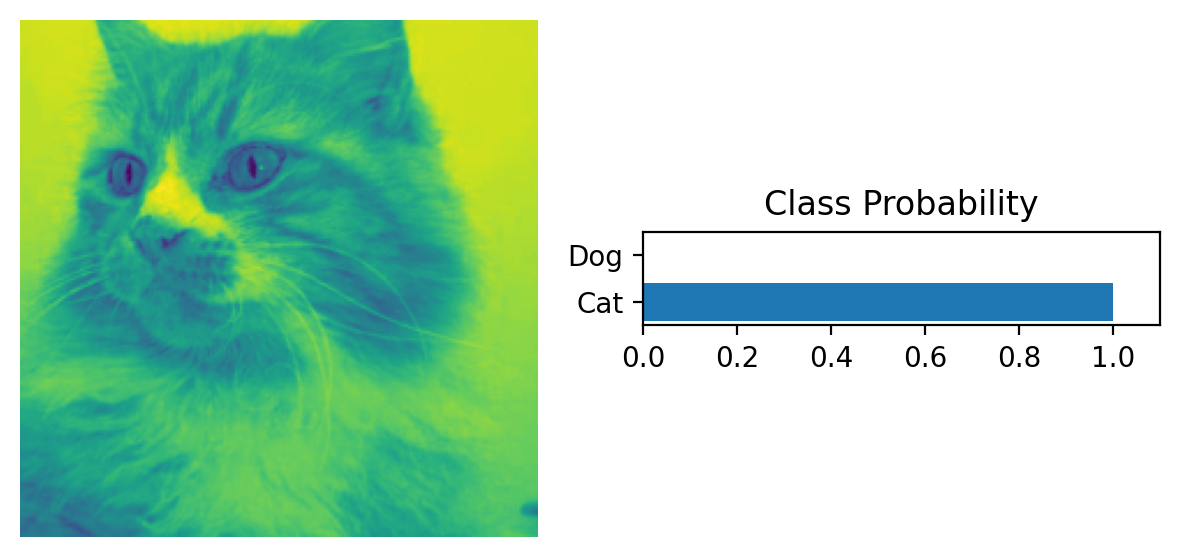

In [116]:
# Importações necessárias
import matplotlib.pyplot as plt
import numpy as np

# Função para exibir a previsão
def view_prediction(image, ps):
    """Mostra a imagem e as probabilidades calculadas."""
    ps = ps.cpu().data.numpy().squeeze()  # Movendo o tensor para a CPU antes de converter para numpy

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.cpu().resize_(1, 224, 224).numpy().squeeze())  # Movendo a imagem para a CPU antes de manipular
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(['Cat', 'Dog'])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# Obtém uma imagem aleatória e a classe correspondente dos dados de teste
images, labels = next(iter(testloader))
idx = np.random.randint(len(images))  # Índice aleatório
image = images[idx].to(device)  # Move a imagem para o dispositivo (GPU)

# Faz a previsão para a imagem
with torch.no_grad():
    model.eval()
    logps = model(image.unsqueeze(0))
    ps = torch.exp(logps)

# Exibe a previsão
view_prediction(image, ps)
plt.show()
